# Kmeans (Find K)
Author: Kim Hazed Delfino

## Imports

In [132]:
import pandas as pd
import numpy as np
# lib for visuals
import matplotlib.pyplot as plt
import seaborn as sns
# Necessary libraries 
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, ConfusionMatrixDisplay

## Load The Data


In [133]:
path = r"C:\Users\kdelfino\Documents\GitHub\Kmean\cust_seg.csv"
df = pd.read_csv(path)

## Exploratory Data Analysis

In [134]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 850 entries, 0 to 849
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       850 non-null    int64  
 1   Customer Id      850 non-null    int64  
 2   Age              850 non-null    int64  
 3   Edu              850 non-null    int64  
 4   Years Employed   850 non-null    int64  
 5   Income           850 non-null    int64  
 6   Card Debt        850 non-null    float64
 7   Other Debt       850 non-null    float64
 8   Defaulted        700 non-null    float64
 9   DebtIncomeRatio  850 non-null    float64
dtypes: float64(4), int64(6)
memory usage: 66.5 KB


In [135]:
df.head()

,Unnamed: 0,Customer Id,Age,Edu,Years Employed,Income,Card Debt,Other Debt,Defaulted,DebtIncomeRatio
0,0,1,41,2,6,19,0.124,1.073,0.0,6.3
1,1,2,47,1,26,100,4.582,8.218,0.0,12.8
2,2,3,33,2,10,57,6.111,5.802,1.0,20.9
3,3,4,29,2,4,19,0.681,0.516,0.0,6.3
4,4,5,47,1,31,253,9.308,8.908,0.0,7.2


In [136]:
# Check for Missing Values
df.isna().sum()

Unnamed: 0           0
Customer Id          0
Age                  0
Edu                  0
Years Employed       0
Income               0
Card Debt            0
Other Debt           0
Defaulted          150
DebtIncomeRatio      0
dtype: int64

- Looks like we have some missing values on `Defaulted` feature, we need to look into it futher to identify the best strategy on how to handle these missing values

In [137]:
df["Unnamed: 0"].nunique()

850

In [138]:
df["Customer Id"].nunique()

850

- Dropping `Unnamed` and `Customer ID` features since they're all unigue and do night provide any commonities that could help clustering algorithm 

In [139]:
# Drop Irrelevant Features
df.drop(columns=["Unnamed: 0", "Customer Id"], inplace=True)

In [140]:
# Double Check
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 850 entries, 0 to 849
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Age              850 non-null    int64  
 1   Edu              850 non-null    int64  
 2   Years Employed   850 non-null    int64  
 3   Income           850 non-null    int64  
 4   Card Debt        850 non-null    float64
 5   Other Debt       850 non-null    float64
 6   Defaulted        700 non-null    float64
 7   DebtIncomeRatio  850 non-null    float64
dtypes: float64(4), int64(4)
memory usage: 53.2 KB


### Distribution using Histogram

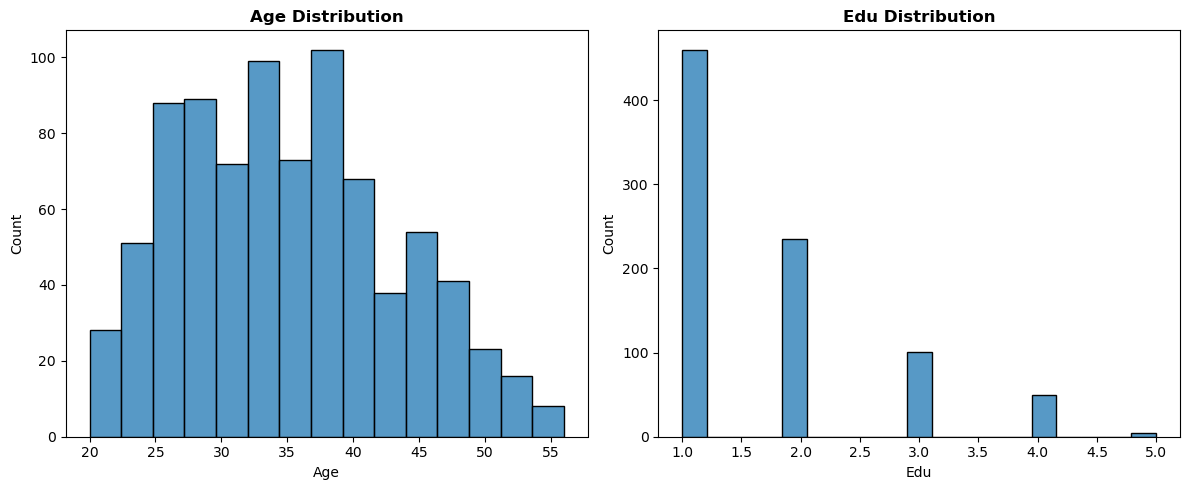

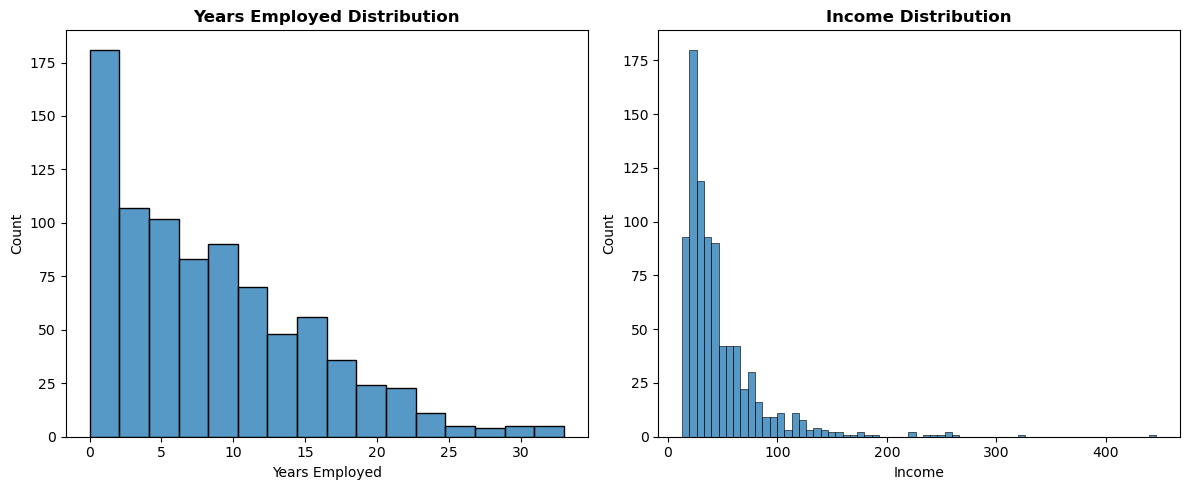

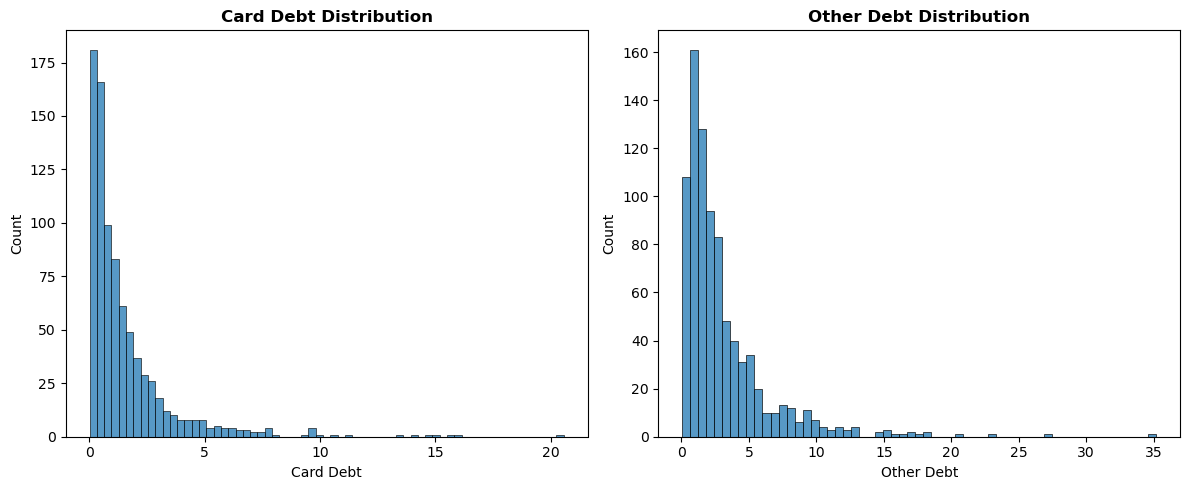

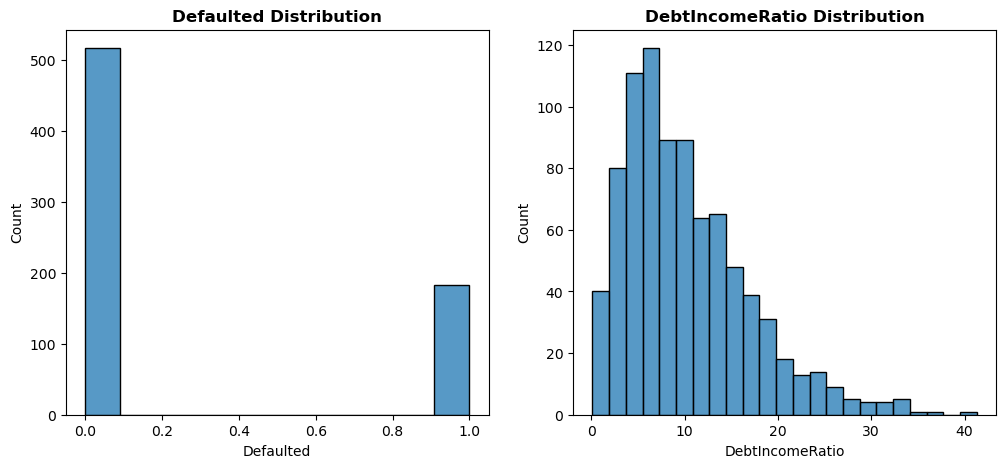

In [141]:
col_ax = 0
row_limit = 3
counter = 0
fig, axes = plt.subplots(ncols=2, figsize=(12,5))
# Iterate to all features and display Historgram
for col in df.columns:
    # Set Historgram 
    ax=sns.histplot(data=df, x=col, ax=axes[col_ax])
    axes[col_ax].set_title(col+" Distribution", fontweight="bold")
    
    # Display every 2 cols and set new fig
    if col_ax == 1 and counter != row_limit:
        fig.tight_layout()
        fig, axes = plt.subplots(ncols=2, figsize=(12,5))
        col_ax = 0
        counter += 1
    else:
        col_ax += 1

- Here we can see the `Distributions` for all features in our dataset
- there are no impossible or questionable values in our dataset 

In [142]:
df.sample(5)

,Age,Edu,Years Employed,Income,Card Debt,Other Debt,Defaulted,DebtIncomeRatio
671,50,1,8,47,0.399,2.844,0.0,6.9
145,28,3,2,30,1.522,4.448,0.0,19.9
211,34,1,10,48,0.264,2.184,NaN,5.1
659,24,1,5,46,0.530,1.218,NaN,3.8
206,33,2,10,26,0.031,0.775,0.0,3.1


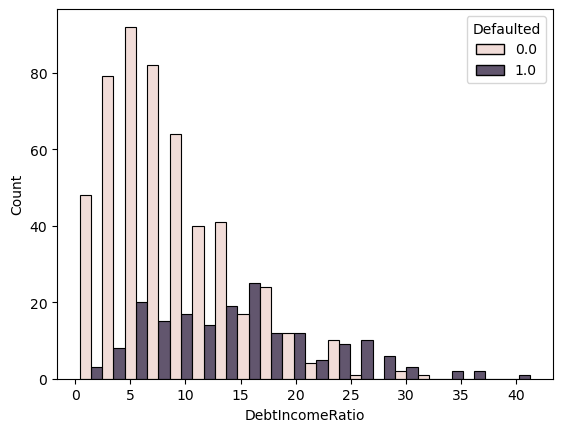

In [143]:
# Display hist for DebtIncomeRation and compare Defaulted 
sns.histplot(data=df, x="DebtIncomeRatio", hue="Defaulted", multiple="dodge");

- There's no clear commonality that would separate Defaulted vs Non-defaulted customers in terms of `DTI (DebtIncomeRatio)`, was hoping to see a fine line where we can easily distinguish defaulted customers based on DTI to help identify the missing values in Defaulted relative to DTI

- that being said , I think the best imputation strategy is to use a `classification model` to predict the missing values in our dataset , other option would be to use `Mode` imputation strategy since it's a categorical feature

### Using `Classification model` to predict missing value in `Defaulted` column

In [144]:
# Create new df without the missing values for training set
train_df = df.dropna(axis=0)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 700 entries, 0 to 849
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Age              700 non-null    int64  
 1   Edu              700 non-null    int64  
 2   Years Employed   700 non-null    int64  
 3   Income           700 non-null    int64  
 4   Card Debt        700 non-null    float64
 5   Other Debt       700 non-null    float64
 6   Defaulted        700 non-null    float64
 7   DebtIncomeRatio  700 non-null    float64
dtypes: float64(4), int64(4)
memory usage: 49.2 KB


In [145]:
# Create df for missing values that we will use for testing set
test_df = df[df["Defaulted"].isna()]
test_df.sample(5)

,Age,Edu,Years Employed,Income,Card Debt,Other Debt,Defaulted,DebtIncomeRatio
775,43,1,15,62,0.694,5.134,NaN,9.4
444,40,1,17,55,2.126,4.144,NaN,11.4
748,22,2,0,14,0.242,2.152,NaN,17.1
266,30,1,12,40,1.249,1.551,NaN,7.0
723,33,1,11,35,0.506,5.059,NaN,15.9


In [146]:
# Split feature matrices and target vector for train set
X_train = train_df.drop(columns="Defaulted")
y_train = train_df["Defaulted"]

# Split feature matrices and target vector for test set
X_test = test_df.drop(columns="Defaulted")
y_pred = test_df["Defaulted"]

In [147]:
# Import Classification model
from sklearn.ensemble import RandomForestClassifier

# Instantiate the model
rf = RandomForestClassifier(random_state=42)

In [148]:
# Fit the model on train set 
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [149]:
# Predict train and test sets
rf_train_pred = rf.predict(X_train)

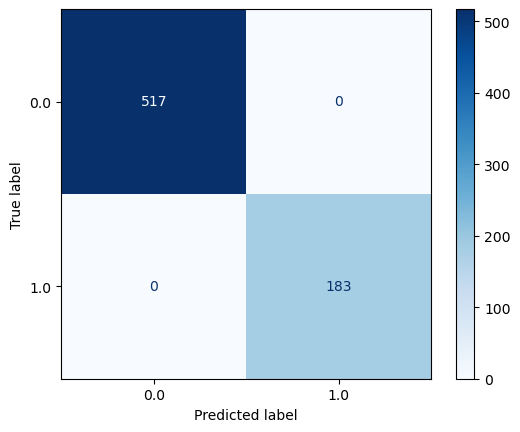

In [150]:
# Check model performance using Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_train, 
                                        rf_train_pred,
                                        cmap="Blues",
                                        normalize=None);





In [151]:
# Replace missing values in y_test using X_test predictions
y_pred = rf.predict(X_test)
y_pred

array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.])

In [152]:
# Import warning filter to remove warning when adding new column to df
import warnings
warnings.filterwarnings("ignore")

In [153]:
# Combine our model prediction to test_df 
test_df["prediction"] = y_pred
test_df

,Age,Edu,Years Employed,Income,Card Debt,Other Debt,Defaulted,DebtIncomeRatio,prediction
5,40,1,23,81,0.998,7.831,NaN,10.9,0.0
8,26,1,5,18,0.575,2.215,NaN,15.5,0.0
11,34,2,9,40,0.374,0.266,NaN,1.6,0.0
13,46,1,6,30,1.415,3.865,NaN,17.6,0.0
15,24,1,1,16,0.185,1.287,NaN,9.2,1.0
...,...,...,...,...,...,...,...,...,...
818,35,2,0,35,2.383,1.957,NaN,12.4,0.0
820,37,1,4,24,0.419,2.989,NaN,14.2,0.0
825,32,2,12,116,4.027,2.585,NaN,5.7,0.0
835,21,3,0,41,2.367,5.628,NaN,19.5,1.0


In [154]:
# Drop the missing value feature
test_df.drop(columns="Defaulted", inplace=True)